In [18]:

library("httr2")

library("jsonlite") # Parse JSON

library("listviewer") # View Json
library("tidyverse")
library(tm)
library(wordcloud)
library(SnowballC)
library(rvest)

# REST API
We start by defining the category of nobel prize we are interested in aswell as the last year of prizes we want to access.
After defining these parameters we can create the URI of our request.

In [19]:
category<-"phy"
yearTo<-"2024"
URI<-sprintf("http://api.nobelprize.org/2.1/nobelPrizes?limit=123&nobelPrizeYear=1901&yearTo=%s&nobelPrizeCategory=%s",yearTo,category)#"http://api.nobelprize.org/2.1/nobelPrizes?limit=123&nobelPrizeYear=1901&yearTo=2024&nobelPrizeCategory=phy"


Once we have the URI we can make a request where the response is returned in the .json format. 

After receiving the response to our request we can can extract the body and convert it from JSON into a dataframe.
From the dataframe we extract the elements in the column "laureates" which in themselves are dataframes and join them into one big dataframe containing information about the laureates of all Nobel prizes from 1901 to 2024.

In [27]:
request <- request(URI)
response <- req_perform(request)
json <- response %>% resp_body_string
data<-jsonlite::fromJSON(json,flatten = TRUE)

data<-bind_rows(data[[1]]["laureates"][[1]], .id = "column_label")


As we are only interested in the words used in motivations we extract these and replace all non word characters with blankspaces. Finally we write the cleaned data to a .txt file in order to use it for our wordcloud.

In [68]:
motivations<-data$motivation.en
motivations<-str_replace_all(motivations, regex("[\\W\\\\ ]")," ")
writeLines(motivations,"data/motivations.txt")

Now we can create the woordcloud.

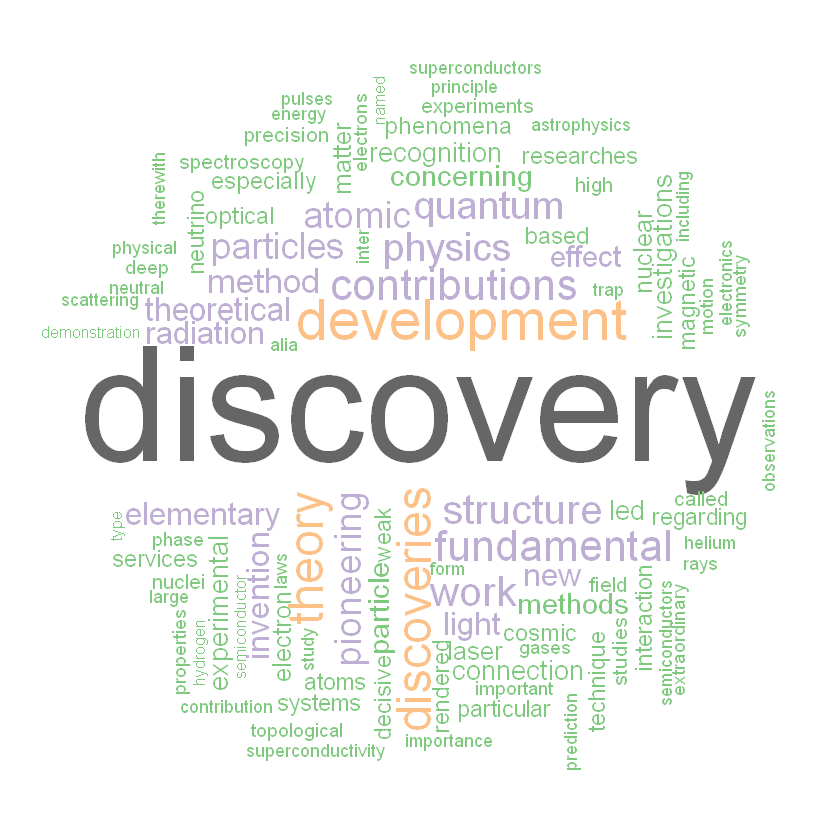

In [102]:
cloud<-Corpus(DirSource("data"))

cloud <- tm_map(cloud, stripWhitespace)

cloud <- tm_map(cloud, tolower)

cloud <- tm_map(cloud, removeWords, stopwords("english"))

wordcloud(cloud
        , scale=c(8,0.5)    
        , max.words=100     
        , random.order=FALSE 
        , rot.per=0.35       
        , use.r.layout=FALSE 
        , colors=brewer.pal(8, "Accent"))


It turns out that discovery is the most frequent word used in prize motivations.

# Webscraper


To create the webscraper we first define the base URL and then a function to easily go between the pages of the webshop.

In [112]:
BASE_URL<-"https://books.toscrape.com/catalogue/"
URL<-function(page=1){return(sprintf("https://books.toscrape.com/catalogue/page-%s.html",page))}
#ht<-rvest::read_html(URL(2))



We can then read the price and rating directly from the first three pages of the catalogue aswell as the URL to the books individual pages.

In [113]:
df<-tibble(Rating=character(),Price=character(),URL=character())
for(i in 1:3){

ht<-rvest::read_html(URL(i))

prod_pod<-ht%>%html_elements(".product_pod")
rating<-prod_pod%>%html_element("p ") %>%html_attrs()
title<-prod_pod%>%html_element("a")%>%html_attrs()
price<-prod_pod%>%html_element(".price_color")%>%html_text()

rating<-str_extract(rating,pattern="(?<=star-rating ).\\w*")

book_url<-sprintf(paste0(BASE_URL,"%s"),as.character(title))
df<-df%>%add_row(tibble(Rating=rating,Price=price,URL=book_url))
}
head(df)

Rating,Price,URL
<chr>,<chr>,<chr>
Three,£51.77,https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html
One,£53.74,https://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html
One,£50.10,https://books.toscrape.com/catalogue/soumission_998/index.html
Four,£47.82,https://books.toscrape.com/catalogue/sharp-objects_997/index.html
Five,£54.23,https://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html
One,£22.65,https://books.toscrape.com/catalogue/the-requiem-red_995/index.html


In order to extract the titles and UPC of the books we need to access these individual pages one by one.

In [114]:
book_url<-df$URL
book_df<-tibble(URL=character(),UPC=character(),Title=character())
for(url in book_url){
    book_page<-rvest::read_html(url)
    title<-(book_page%>%html_elements("h1")%>%html_text2())[[1]]
    upc<-(book_page%>%html_elements("table")%>%html_table())[[1]][1,2][[1]]
    book_df<-book_df%>%add_row(URL=url,UPC=upc,Title=title)
    
}
head(book_df)


URL,UPC,Title
<chr>,<chr>,<chr>
https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html,a897fe39b1053632,A Light in the Attic
https://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html,90fa61229261140a,Tipping the Velvet
https://books.toscrape.com/catalogue/soumission_998/index.html,6957f44c3847a760,Soumission
https://books.toscrape.com/catalogue/sharp-objects_997/index.html,e00eb4fd7b871a48,Sharp Objects
https://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html,4165285e1663650f,Sapiens: A Brief History of Humankind
https://books.toscrape.com/catalogue/the-requiem-red_995/index.html,f77dbf2323deb740,The Requiem Red


After we have the two dataframes containing rating and prices and the UPC and title of each book we can then join them by the column URL.
We then select all columns except URL and reorder them.

In [117]:
df<-df%>%left_join(by=join_by(URL),book_df)%>%select(!URL)
df<-df%>%relocate(UPC,Title,Price,Rating)


Finally we can display the end result for a selection of books

In [118]:
table_list<-list(
"a897fe39b1053632",	
"90fa61229261140a",
"6957f44c3847a760",
"e00eb4fd7b871a48",
"4165285e1663650f")
df%>%filter(UPC %in% table_list)


UPC,Title,Price,Rating
<chr>,<chr>,<chr>,<chr>
a897fe39b1053632,A Light in the Attic,£51.77,Three
90fa61229261140a,Tipping the Velvet,£53.74,One
6957f44c3847a760,Soumission,£50.10,One
e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
